# Feature Engineering

While my primary models will be transformer-based (which learn features from text directly), I also engineer some intuitive features for analysis and potential baseline models:
- **Lexical Diversity:** ratio of unique words to total words (higher = more varied vocabulary).
- **Readability and Sentiment:** (Already computed in EDA) can be considered features as well.

These features can help us interpret the data and also try a classic ML approach (e.g., Random Forest) to see how it performs relative to transformers. In this notebook, I will:
1. Compute the lexical diversity for each entry.
2. (Optional) Train a simple classifier on these features + TF-IDF as a comparison.

Let's begin by loading the datasets.


In [1]:
# move up one level so that works
import os
os.chdir(os.path.abspath(os.path.join(os.getcwd(), "..")))
print("new cwd:", os.getcwd())


new cwd: c:\Testing\Final_Year_Project\AI-Text-Detection-Tool


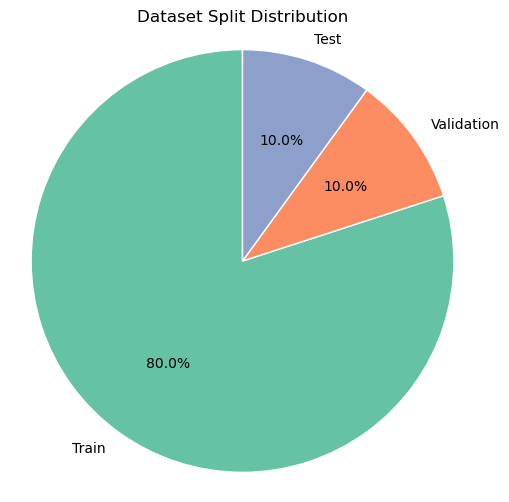

In [4]:
import matplotlib.pyplot as plt

# Assuming you’ve already done:
# train_df = pd.read_parquet("data/train_dataset.parquet")
# val_df   = pd.read_parquet("data/val_dataset.parquet")
# test_df  = pd.read_parquet("data/test_dataset.parquet")

sizes = [len(train_df), len(val_df), len(test_df)]
labels = ['Train', 'Validation', 'Test']
colors = ['#66c2a5', '#fc8d62', '#8da0cb']

plt.figure(figsize=(6,6))
plt.pie(
    sizes,
    labels=labels,
    autopct='%1.1f%%',
    startangle=90,
    colors=colors,
    wedgeprops={'edgecolor':'w'}
)
plt.title('Dataset Split Distribution')
plt.axis('equal')  # ensure pie is drawn as a circle
plt.show()


## Compute Lexical Diversity

We now compute the lexical diversity feature (type‑token ratio) for each split.


In [3]:
# Compute lexical diversity for each set
train_df['lexical_diversity'] = train_df['text'].apply(features.compute_lexical_diversity)
val_df['lexical_diversity']   = val_df['text'].apply(features.compute_lexical_diversity)
test_df['lexical_diversity']  = test_df['text'].apply(features.compute_lexical_diversity)

# Sanity check: example and class means
print("Example lex diversity:", train_df.loc[0, 'text'][:50], "...", train_df.loc[0, 'lexical_diversity'])
print("Avg lexical diversity (train) by class:")
print(train_df.groupby('label')['lexical_diversity'].mean().to_dict())


Example lex diversity: the wait for rick and morty's next season has been ... 0.62
Avg lexical diversity (train) by class:
{'ai_generated': 0.6705305810137545, 'ai_paraphrased': 0.6874178639528855, 'human_written': 0.6256921113334357}


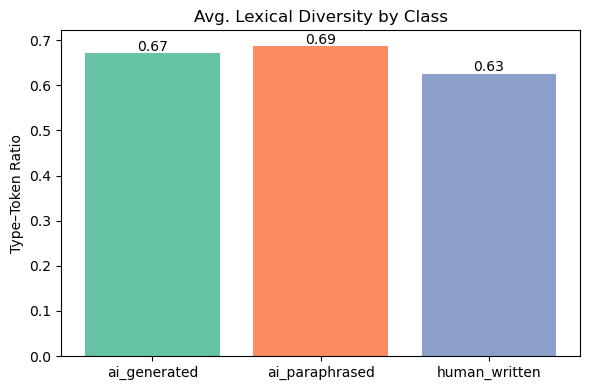

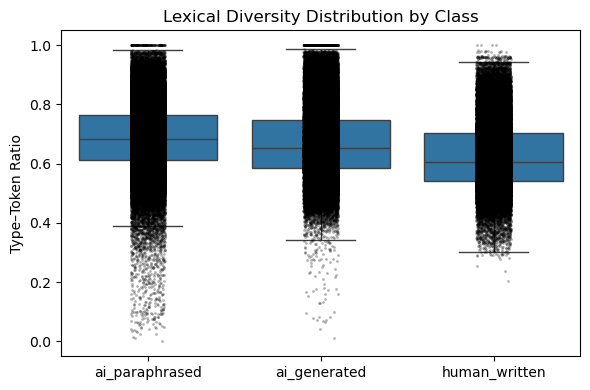

In [6]:
import matplotlib.pyplot as plt
import seaborn as sns

# 1) Average TTR: Matplotlib bar → no warning
lex_avg = train_df.groupby('label')['lexical_diversity'].mean().reset_index()
colors = ['#66c2a5','#fc8d62','#8da0cb']  # Set2 palette

plt.figure(figsize=(6,4))
plt.bar(lex_avg['label'], lex_avg['lexical_diversity'], color=colors)
plt.title("Avg. Lexical Diversity by Class")
plt.ylabel("Type–Token Ratio")
plt.xlabel("")
for i, h in enumerate(lex_avg['lexical_diversity']):
    plt.text(i, h+0.005, f"{h:.2f}", ha='center')
plt.tight_layout()
plt.show()


# 2) Distribution: Seaborn box+strip, drop palette
plt.figure(figsize=(6,4))
ax = sns.boxplot(
    data=train_df,
    x='label',
    y='lexical_diversity',
    showfliers=False
)
sns.stripplot(
    data=train_df,
    x='label',
    y='lexical_diversity',
    color='k',
    size=2,
    alpha=0.3,
    dodge=True,
    ax=ax
)
ax.set_title("Lexical Diversity Distribution by Class")
ax.set_ylabel("Type–Token Ratio")
ax.set_xlabel("")
plt.tight_layout()
plt.show()


## Baseline Model (Random Forest + TF‑IDF)

To gauge how well simple features plus TF‑IDF can perform, I train a Random Forest classifier using:
- Readability, sentiment, and lexical diversity
- TF‑IDF vectors (top 1,000 features)

This gives us a baseline to compare against our transformer models.


In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
import numpy as np

# Prepare engineered features
train_feats = pd.DataFrame({
    'readability': train_df['text'].apply(features.compute_readability),
    'sentiment':   train_df['text'].apply(features.compute_sentiment),
    'lexical_diversity': train_df['lexical_diversity']
})
val_feats = pd.DataFrame({
    'readability': val_df['text'].apply(features.compute_readability),
    'sentiment':   val_df['text'].apply(features.compute_sentiment),
    'lexical_diversity': val_df['lexical_diversity']
})

# TF‑IDF
vectorizer = TfidfVectorizer(max_features=1000, stop_words='english')
tfidf_train = vectorizer.fit_transform(train_df['text'])
tfidf_val   = vectorizer.transform(val_df['text'])

# Combine
X_train = np.hstack([train_feats.values, tfidf_train.toarray()])
X_val   = np.hstack([val_feats.values, tfidf_val.toarray()])
y_train = train_df['label']
y_val   = val_df['label']

# Train Random Forest
clf = RandomForestClassifier(n_estimators=100, random_state=42)
clf.fit(X_train, y_train)
y_pred = clf.predict(X_val)

# Report
print("Baseline Random Forest Performance:")
print(classification_report(y_val, y_pred, digits=3))


In [ ]:
# %% [markdown]
# ### Baseline Random Forest — Visual Evaluation

# %% [code]
import numpy as np
from utils import viz

# 1) Confusion matrix
fig_cm = viz.plot_confusion_matrix(
    y_val, 
    y_pred, 
    labels=clf.classes_.tolist(), 
    normalize=False, 
    save_path="diagrams/baseline_confusion_matrix.png"
)
plt.show()

# 2) ROC curves (one‑vs‑rest)
y_prob = clf.predict_proba(X_val)
fig_roc = viz.plot_roc_curves(
    y_true=np.array([list(clf.classes_).index(l) for l in y_val]),
    y_prob=y_prob,
    class_names=clf.classes_.tolist(),
    save_path="diagrams/baseline_roc_curves.png"
)
plt.show()

# 3) Precision‑Recall curves
fig_pr = viz.plot_pr_curves(
    y_true=np.array([list(clf.classes_).index(l) for l in y_val]),
    y_prob=y_prob,
    class_names=clf.classes_.tolist(),
    save_path="diagrams/baseline_pr_curves.png"
)
plt.show()


## Save Features (optional)

I save the datasets with our newly computed features in case I want to reuse them later (for error analysis, ensembling, etc.).


In [ ]:
# Save datasets with features added
train_df.to_parquet("data/train_with_features.parquet", index=False)
val_df.to_parquet("data/val_with_features.parquet", index=False)
test_df.to_parquet("data/test_with_features.parquet", index=False)
print("Saved train/val/test with features to disk.")
